## 作業
礙於不是所有同學都有 GPU ，這邊的範例使用的是簡化版本的 ResNet，確保所有同學都能夠順利訓練!


最後一天的作業請閱讀這篇非常詳盡的[文章](https://blog.gtwang.org/programming/keras-resnet-50-pre-trained-model-build-dogs-cats-image-classification-system/)，基本上已經涵蓋了所有訓練　CNN 常用的技巧，請使用所有學過的訓練技巧，盡可能地提高 Cifar-10 的 test data 準確率，截圖你最佳的結果並上傳來完成最後一次的作業吧!

另外這些技巧在 Kaggle 上也會被許多人使用，更有人會開發一些新的技巧，例如使把預訓練在 ImageNet 上的模型當成 feature extractor 後，再拿擷取出的特徵重新訓練新的模型，這些技巧再進階的課程我們會在提到，有興趣的同學也可以[參考](https://www.kaggle.com/insaff/img-feature-extraction-with-pretrained-resnet)

In [13]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

num_classes = 2
inputH = 128
inputW = 128

In [2]:
# load data

trainAnnotationList = []
testAnnotationList = []

dirPath = "../../data/final_kaggle_data/kaggle_dogcat/train/cats"
for fileName in os.listdir(dirPath):
    filePath = os.path.join(dirPath, fileName)
    trainAnnotationList.append([filePath, 0])
    
dirPath = "../../data/final_kaggle_data/kaggle_dogcat/train/dogs"
for fileName in os.listdir(dirPath):
    filePath = os.path.join(dirPath, fileName)
    trainAnnotationList.append([filePath, 1])
    
dirPath = "../../data/final_kaggle_data/kaggle_dogcat/test"
for fileName in os.listdir(dirPath):
    filePath = os.path.join(dirPath, fileName)
    testAnnotationList.append(filePath)
    
random.shuffle(trainAnnotationList)

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

x_train = np.zeros([len(trainAnnotationList),inputH,inputW,3], np.float32)
y_train = np.zeros([len(trainAnnotationList),1], np.float32)
x_test  = np.zeros([len(testAnnotationList),inputH,inputW,3], np.float32)

for idx, trainAnnotation in enumerate(trainAnnotationList):
    img = cv2.imread(trainAnnotation[0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    imgH, imgW = img.shape[0:2]
    imgS = imgH if imgH > imgW else imgW
    padH = imgS - imgH
    padW = imgS - imgW
    img = cv2.copyMakeBorder(img,padH//2,padH//2,padW//2,padW//2,cv2.BORDER_CONSTANT)
    
    img = cv2.resize(img, (inputW, inputH))
    x_train[idx] = img
    y_train[idx] = trainAnnotation[1]
    
for idx, testAnnotation in enumerate(testAnnotationList):
    img = cv2.imread(testAnnotation)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    imgH, imgW = img.shape[0:2]
    imgS = imgH if imgH > imgW else imgW
    padH = imgS - imgH
    padW = imgS - imgW
    img = cv2.copyMakeBorder(img,padH//2,padH//2,padW//2,padW//2,cv2.BORDER_CONSTANT)
    
    img = cv2.resize(img, (inputW, inputH))
    x_test[idx] = img
    
x_train = x_train / 255.
x_test = x_test / 255.
y_train = to_categorical(y_train, num_classes)

array([0., 1.], dtype=float32)

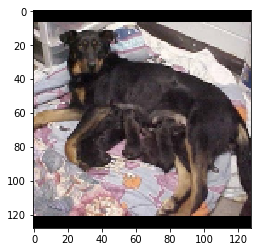

In [11]:
# for training data
idx = 5
plt.imshow(x_train[idx])
y_train[idx]

# Training

In [14]:
input_tensor = tf.keras.Input([inputH,inputW,3], name='input')
backbone_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_tensor=input_tensor, 
    alpha=0.5, 
    #depth_multiplier=1, 
    include_top=False, 
    weights='imagenet')
#backbone_model.summary()

c:\users\qwerz\miniconda3\envs\ml100\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [16]:
out = backbone_model.get_layer('block_9_add').output
out = tf.keras.layers.GlobalAveragePooling2D(name='GAP')(out)
out = tf.keras.layers.Flatten(name='Flatten')(out)
out = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_initializer='he_normal', name='output')(out)

model = tf.keras.Model(inputs=input_tensor, outputs=out, name='Model')
model.summary()

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 16)   64          Conv1[0][0]                      
______________________________________________________________________________________________

In [17]:
for layer in model.layers[:37]:
    print(layer.name)
    layer.trainable = False

input
Conv1_pad
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN


In [71]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.SGD(1e-4, 0.9),
              metrics=['accuracy'])

In [72]:
batch_size = 32
epochs = 30
valid_num = 100

from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(factor=0.5,
                              min_lr=1e-12,
                              monitor='loss',
                              patience=5,
                              verbose=1)

history = model.fit(x_train[:], y_train[:],
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_train[:valid_num], y_train[:valid_num]),
                    callbacks=[reduce_lr])

Train on 4000 samples, validate on 100 samples
Epoch 1/30
4000/4000 [==============================] - 9s 2ms/sample - loss: 0.0052 - accuracy: 0.9980 - val_loss: 0.0154 - val_accuracy: 1.0000
Epoch 2/30
4000/4000 [==============================] - 7s 2ms/sample - loss: 0.0072 - accuracy: 0.9980 - val_loss: 0.0139 - val_accuracy: 1.0000
Epoch 3/30
4000/4000 [==============================] - 6s 2ms/sample - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.0135 - val_accuracy: 1.0000
Epoch 4/30
4000/4000 [==============================] - 6s 2ms/sample - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.0138 - val_accuracy: 1.0000
Epoch 5/30
1248/4000 [========>.....................] - ETA: 4s - loss: 0.0070 - accuracy: 0.9976

KeyboardInterrupt: 

In [23]:
score = model.evaluate(x_train[:valid_num], y_train[:valid_num], verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.01864005610346794
Test accuracy: 1.0


# Testing

pred [5.4910684e-05 9.9994504e-01]
ans [0. 1.]


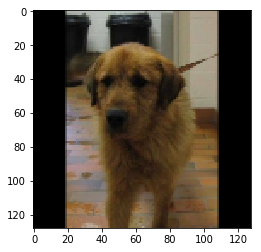

In [29]:
# for training data
idx = 900
plt.imshow(x_train[idx])

pred = model.predict(x_train[idx:idx+1])
print("pred", pred[0])
print("ans", y_train[idx])

pred [0]


array([[9.9999344e-01, 6.5639692e-06]], dtype=float32)

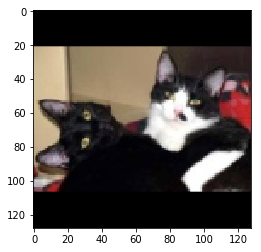

In [53]:
# for testing data
idx = 9
plt.imshow(x_test[idx])

pred = model.predict(x_test[idx:idx+1])
print("pred", np.argmax(pred, axis=-1))
pred

6.5639692e-06

## submission

In [62]:
pred_test = model.predict(x_test)

In [68]:
import pandas as pd
data = []
for i in range(len(x_test)):
    data.append(["{:03d}".format(i), pred_test[i][1]])

# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['ID', 'Predicted']) 
df.head()

,ID,Predicted
0,000,0.052348
1,001,0.980427
2,002,0.000001
3,003,0.999993
4,004,0.000016


In [70]:
df.to_csv("./submission.csv", index=False)

## backup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

exp = 6

def mynet_block(inputs,
                num_filters=16,
                kernel_size=3,
                strides=1,
                activation='relu',
                name='MB'):
    
    in_filters = inputs.get_shape()[-1]
    x = inputs
    if strides==1 and in_filters==num_filters:
        # head
        x = Conv2D(num_filters*exp, 1, 1, padding='same', 
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4), name=name+'/conv_head') (x)
        x = BatchNormalization(name=name+'/bn_head')(x)
        x = Activation(activation, name=name+'/act_head')(x)
        # mid
        x = keras.layers.DepthwiseConv2D(kernel_size, padding='same', name=name+'/conv') (x)
        x = BatchNormalization(name=name+'/bn')(x)
        x = Activation(activation, name=name+'/act')(x)
        # tail
        x = Conv2D(num_filters, 1, 1, padding='same', 
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4), name=name+'/conv_tail') (x)
        x = BatchNormalization(name=name+'/bn_tail')(x)
        x = Add(name=name+'/add')([x, inputs])
    else:
        x = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4), name=name+'/conv')(x)
        x = BatchNormalization(name=name+'/bn')(x)
        x = Activation(activation, name=name+'/act')(x)
    return x

In [ ]:
inputs = Input(shape=[inputH,inputW,3], name='input')
out = inputs
out = mynet_block(out, 8, strides=2, name="RL0")
out = mynet_block(out, 16, strides=2, name='RL1')
out = mynet_block(out, 16, strides=1, name='RL2')
out = mynet_block(out, 16, strides=1, name='RL3')
out = mynet_block(out, 32, strides=2, name='RL4')
out = mynet_block(out, 32, strides=1, name='RL5')
out = mynet_block(out, 32, strides=1, name='RL6')
out = mynet_block(out, 64, strides=2, name='RL7')
out = mynet_block(out, 64, strides=1, name='RL8')
out = mynet_block(out, 64, strides=1, name='RL9')

out = GlobalAveragePooling2D(name='GAP')(out)
out = Flatten(name='Flatten')(out)
out = Dense(num_classes, activation='softmax', kernel_initializer='he_normal', name='output')(out)

model = Model(inputs=inputs, outputs=out, name='Model')
model.summary()